# Atrial Fibrillation classification using Deep Learning

In [2]:
import numpy as np
import pandas as pd
import wfdb # for reading signal files
import os 
import neurokit2 as nk
import pywt 
import glob 
import h5py
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns 
from tqdm.notebook import tqdm

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

## The dataset

The dataset was obtained from the 2017 Physionet AFib challenge, containing $8528$ records (labeled 'A00001' to 'A08527') in MATLAB header files. The contents of these files can be read using Python's WFDB library. Since the data was collected from a handheld ECG device, not all samples are of the same size. The maximum signal length in the dataset is $18,286$ samples, which amounts to $60.95\:\rm{s}$ given that the sampling rate is $300\:\rm{Hz}$. On the otherhand, the minimum signal length is $2,714$, which is just over $9\:\rm{s}$.

In [3]:
data_list = sorted(glob.glob('./../data/*.mat')) 
data_list = [os.path.splitext(x)[0] for x in data_list] # strips the .mat extensions from the list
#label_list = pd.read_csv('./../data/REFERENCE.csv', header=None, names=['record num', 'diagnosis'])
label_list = pd.read_csv('./../data/REFERENCE.csv', index_col=[0])

'''
Function for generating single sample signals from wfdb file
'''
def sample_record(data, n):
    sample = data[n]
    record = wfdb.rdrecord(sample)
    return record.__dict__['p_signal'].flatten()

'''
Sample wfdb file
'''

print(wfdb.rdrecord('./../data/A00001').__dict__)

{'record_name': 'A00001', 'n_sig': 1, 'fs': 300, 'counter_freq': None, 'base_counter': None, 'sig_len': 9000, 'base_time': datetime.time(5, 5, 15), 'base_date': datetime.date(2000, 5, 1), 'comments': [], 'sig_name': ['ECG'], 'p_signal': array([[-0.127],
       [-0.162],
       [-0.197],
       ...,
       [-0.018],
       [-0.022],
       [-0.021]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['A00001.mat'], 'fmt': ['16'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [24], 'adc_gain': [1000.0], 'baseline': [0], 'units': ['mV'], 'adc_res': [16], 'adc_zero': [0], 'init_value': [-127], 'checksum': [0], 'block_size': [0]}


In [4]:
label_list.head(5)

,record num,diagnosis,label
0,A00001,N,1
1,A00002,N,1
2,A00003,N,1
3,A00004,A,0
4,A00005,A,0


The dataset consists of four kinds heart rhythms (discussions to follow). It is apparent that this is quite an unbalanced dataset, which should be taken into account during training. Furthermore, the diagnosis column should be encoded for training and testing purposes. After label encoding, we have

$$ \{ \rm{A} : 0, \rm{N} : 1, \rm{O} : 2, ~ : 3 \} $$

In [5]:
le = LabelEncoder()
label_list['label'] = le.fit_transform(label_list['diagnosis'].values)
label_list.head(5)

,record num,diagnosis,label
0,A00001,N,1
1,A00002,N,1
2,A00003,N,1
3,A00004,A,0
4,A00005,A,0


In [6]:
#label_list.to_csv('./../data/REFERENCE.csv')

In [7]:
# Simple statistics on diagnosis

label_list_stats = label_list.groupby('diagnosis').agg('count').reset_index()
#label_list_stats.columns = ['diagnosis', 'occurrences']

label_list_stats

,diagnosis,record num,label
0,A,738,738
1,N,5050,5050
2,O,2456,2456
3,~,284,284


In [8]:
# Histogram of signal lengths

label_list_copied = label_list.copy()
label_list_copied['signal length'] = ''

for n in range(len(data_list)):
    record = wfdb.rdrecord(data_list[n])
    sig_len = record.__dict__['sig_len']
    label_list_copied.loc[n, 'signal length'] = sig_len

In [9]:
print('Minimum signal length: ' + str(label_list_copied['signal length'].min()))
print('Maximum signal length: ' + str(label_list_copied['signal length'].max()))

Minimum signal length: 2714
Maximum signal length: 18286


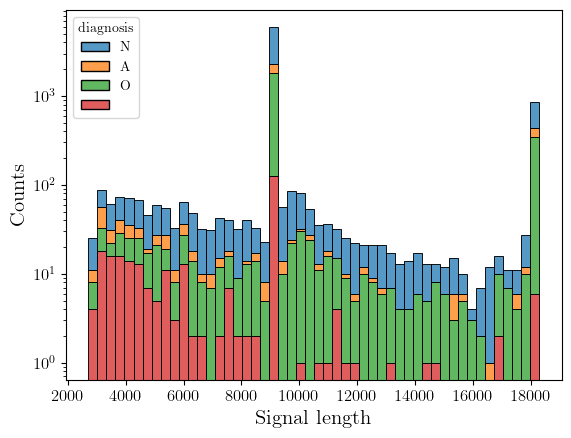

In [10]:
fig, ax = plt.subplots()

sns.histplot(data=label_list_copied, x='signal length', hue='diagnosis', bins=50, multiple='stack')
plt.yscale('log')
plt.xlabel(r'Signal length', fontsize=15)
plt.ylabel(r'Counts', fontsize=15)
#plt.savefig('./images/sig_len_stats.png', dpi=300, bbox_inches='tight')
plt.show()

Each entry in the dataset contains, apart from the signal array, information such as sample rate (for the signals here is $300\:\rm{Hz}$). The dataset contains four distinct types of ECG recordings (shown below) - (a) normal sinus rhythm (N), (b) afib rhythm (A), (c) other/unclassified rhythm (O) and (d) noise (~). A normal sinus rhythm comprises of distiguishable of P- and T- waves and QRS complexes. Moreover, provided that the recording is being carried out in a steady environment, the time-lapse between successive QRS complexes is constant. The afib rhythm, on the otherhand, apart from unevenly spaced QRS complexes, also display a clear lack of P-waves.

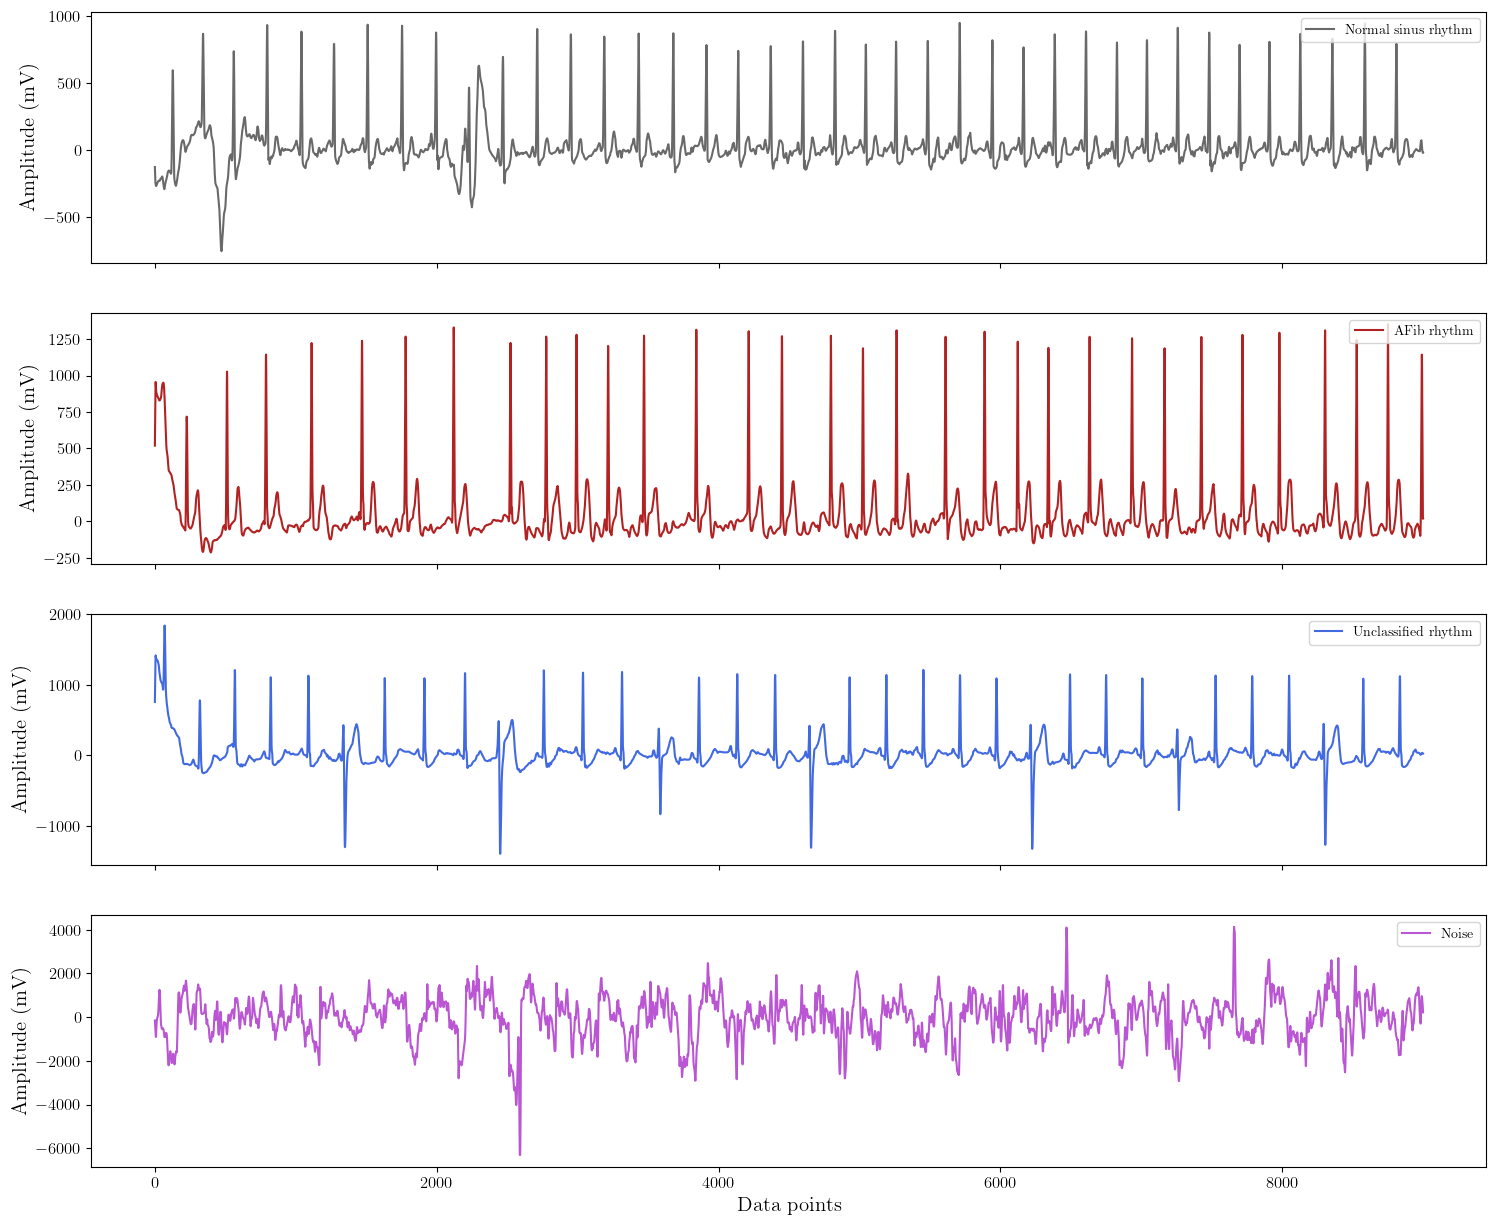

In [11]:
fig, ax = plt.subplots(4, 1, figsize=(18, 15), sharex=True)

color=['dimgray', 'firebrick', 'royalblue', 'mediumorchid']

ax[0].plot(sample_record(data_list, 0)*1000, label='Normal sinus rhythm', color=color[0])
ax[0].set_ylabel(r'Amplitude (mV)', fontsize=15)
ax[0].legend(loc='upper right')
ax[1].plot(sample_record(data_list, 3)*1000, label='AFib rhythm', color=color[1])
ax[1].set_ylabel(r'Amplitude (mV)', fontsize=15)
ax[1].legend(loc='upper right')
ax[2].plot(sample_record(data_list, 76)*1000, label='Unclassified rhythm', color=color[2])
ax[2].set_ylabel(r'Amplitude (mV)', fontsize=15)
ax[2].legend(loc='upper right')
ax[3].plot(sample_record(data_list, 1245)*1000, label='Noise', color=color[3])
ax[3].set_ylabel(r'Amplitude (mV)', fontsize=15)
ax[3].set_xlabel(r'Data points', fontsize=15)
ax[3].legend(loc='upper right')

#plt.savefig('./images/ecg_examples.png', dpi=300, bbox_inches='tight')
plt.show()

## Identifying features in signals

The features that are present in each cycle of a normal sinus rhythm in ECG signals are 
1. a P-wave representing the electrical depolarization of the atria of the heart, shown as a small positive deflection of the baseline.
2. a QRS complex representing the ventricular contraction (systole), consisting of a Q-wave (the first negative deflection), followed by an R- wave (a strong positive deflection from the baseline) and a subsequent negative dip termed as the S-wave.
3. The QRS complex is followed by a T-wave, which is a small positive deflection similar to the P-wave, indicating ventricular repolarization.

A single ECG cycle is shown below

<img src='.\images\ecg.png' class='center' width='600' height='400'>

It can be seen that the time interval between these different P- and T- waves and the QRS complexes also play a big role in determining what an ECG signal looks like. These features can be detected using the Python library *neurokit2*. The signal is first cleaned of noise and passed though nk.ecg_peaks() and nk.ecg_delineate() functions. The nk.ecg_delineate() function can produce a plot of all the ECG cycles stacked with the P- and T- waves and QRS complexes identified. Below, the signal for A00001 is plotted where it can be seen that the different peaks approximately line up when superposed.

In [23]:
def return_peaks(signal):

    signal_trunc = 1000*signal[2500:]

    processed_signal = nk.ecg_process(
        signal_trunc,
        sampling_rate=300,
        method='hamilton2002'
    )

    signal_cleaned = processed_signal[0]['ECG_Clean']
    _, rpeaks = nk.ecg_peaks(signal_cleaned, sampling_rate=300)
    _, wave_peaks = nk.ecg_delineate(
        signal_cleaned,
        rpeaks,
        sampling_rate=300,
        method='peak',
        show=True,
        show_type='peaks'
    )

    return wave_peaks

P-wave peak locations: [177, 407, 649, 885, 1136, 1372, 1603, 1830, 2066, 2294, 2506, 2706, 2952, 3167, 3404, 3632, 3839, 4066, 4295, 4508, 4728, 4943, 5147, 5375, 5588, 5814, 6056, nan]


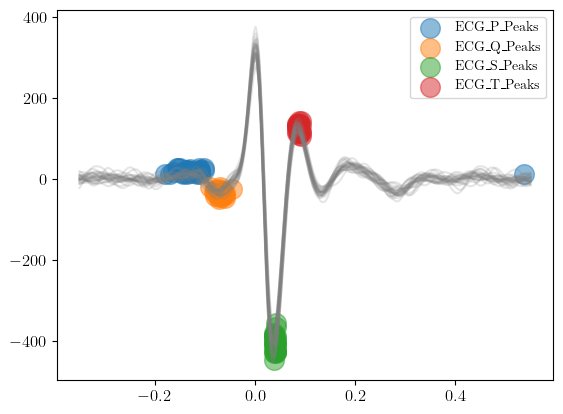

In [24]:
# Record number A00001: normal sinus rhythm

ecg_sig1 = sample_record(data_list,0)

peaks1 = return_peaks(ecg_sig1)

print('P-wave peak locations: ' + str(peaks1['ECG_P_Peaks']))

One the otherhand, when A00004 is plotted using nk.ecg_delineate(), the uneven rhythm means that the ECG cycles cannot be superposed together into a coherent P-QRS-T sequence. Furthermore, a tell-tale sign of atrial fibrillation is the absence of P-waves. In the array wave_peaks2, it can be seen that certain P-waves are shown as NaN.

P-wave peak locations: [262, 438, 692, 943, 1287, 1624, nan, 2227, 2491, 2729, 3074, 3320, nan, 3809, 4093, 4382, 4633, 4894, 5141, 5417, 5753, nan, nan]


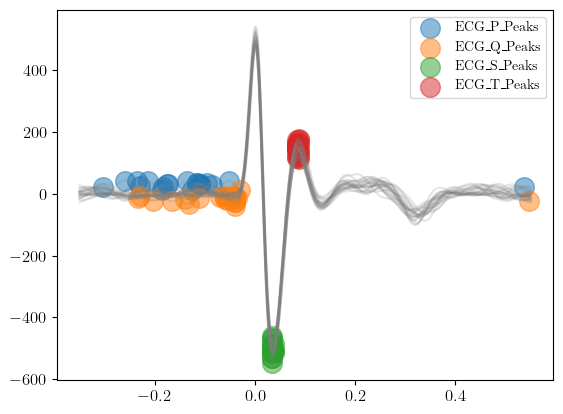

In [25]:
ecg_sig2 = sample_record(data_list,3)

peaks2 = return_peaks(ecg_sig2)

print('P-wave peak locations: ' + str(peaks2['ECG_P_Peaks']))

Although searching for the presence (or lack thereof) of P-waves sounds reasonable, sometimes signals received from handheld ECG devices are not clean, even after processessing, such that these features might become misleading. Moreover, results may vary depending on the particular QRS detection algorithm used. All of these make feature-based detection a very complicated process. One way which streamlines detection is one in which signals can be learned by deep learning algorithms. One popular way to perform this task is to convert $1d$ signals into $2d$ scaleogram images through wavelet transforms and training such images on a convolutional neural network (CNN).

## Wavelet transforms

Before talking about wavelet transforms, one might think why not use Fourier transforms? The reason why Fourier transforms are not preferred can be understood in terms of the uncertainty principle
$$ \Delta t\Delta\omega \geq \frac{1}{2} $$
Hence, by trying to measure the frequency content $\tilde{f}(\omega)$ of a signal precisely, we lose information on the temporal evolution of the signal. Hence, non-stationary signals (such as chirps and ECGs) cannot be modeled well using traditional Fourier transforms. Improvements on the Fourier transform such as short-time Fourier transforms (STFTs) also suffer from resolution issues because of the fixed size of the averaging window function. Wavelet transforms, on the otherhand, not only tell us what frequencies are present in the signal, but also at which time these frequencies occurred - they perform a multiresolution analysis.

Consider a family of orthonormal basis function 
$$ \psi_{jk}(t)=2^{j/2}\psi\left( 2^j t - k \right),\;\;\;\; j,k\in\mathbb{Z} $$
where the function $\psi$ is called an orthonormal wavelet if
$$ \langle \psi_{jk},\psi_{\ell m} \rangle=\int_{-\infty}^\infty dt\:\psi_{jk}(t)\overline{\psi_{\ell m}(t)}=\delta_{j\ell}\delta_{km} $$
Any signal in the time domain can be expressed as a linear combination of these basis functions
$$ f(t)=\sum_{j,k=-\infty}^\infty c_{jk}\psi_{jk}(t) $$
in the form of a *wavelet series*. The *integral wavelet transform* is defined as
$$ \left[ W_\psi f \right](a,b)=\frac{1}{\sqrt{a}}\int_{-\infty}^\infty dt\:f(t)\overline{\psi\left( \frac{t-b}{a} \right)} $$
The coefficients are then given by
$$ c_{jk}=\left[ W_\psi f \right]\left( 2^{-j}, 2^{-j}k \right) $$
where $a=2^{-j}$ and $b=2^{-j}k$ are called dyadic dilation and position respectively.

Here is an example of a non-stationary chirp signal of the following form

$$ X(t)=e^{-(t-t_0)^2/2\sigma^2}\left[ \sin\left( 2\pi f_1(t)t \right) + 0.6\sin\left( 2\pi f_2(t)t \right) \right] $$
where $f_{1,2}(t)$ are two time-dependent frequencies. A $2d$ plot, called a *scaleogram*, can be produced after the CWT operation. In this case, using complex Morlet wavelets
$$ \psi(t)=\frac{1}{\sqrt{\pi B}}e^{-t^2/B}e^{2\pi i C t} $$
where $B$ is the bandwidth and $C$ is the center frequency.

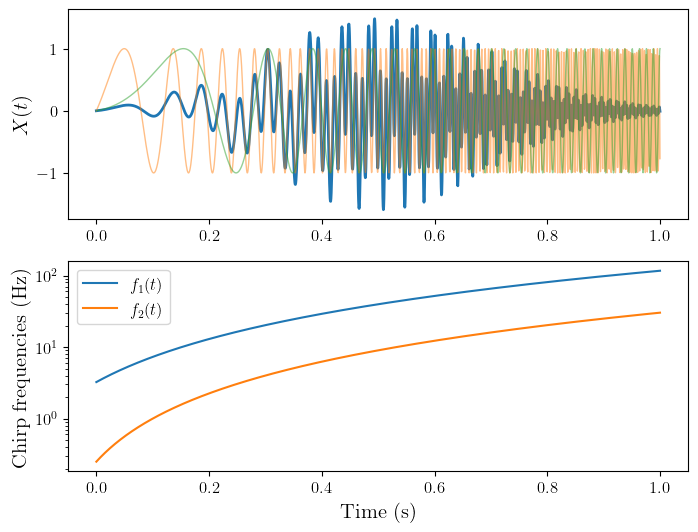

In [15]:
''' 
Example of continuous wavelet transform on a chirp signal
'''
def gaussian(x, x0, sigma):
    return np.exp( -0.5*((x - x0)/sigma)**2 )

def make_chirp(t, t0, a):
    freq = (a*(t + t0))**2
    chirp = np.sin(2*np.pi*freq*t)
    return chirp, freq 

t = np.linspace(0, 1, 2000)
chirp1, freq1 = make_chirp(t, 0.2, 9)
chirp2, freq2 = make_chirp(t, 0.1, 5)
chirp = chirp1 + 0.6*chirp2 
chirp = chirp*gaussian(t, 0.5, 0.2)

fig, ax = plt.subplots(2, 1, figsize=(8,6))

ax[0].plot(t, chirp, linewidth=2)
ax[0].plot(t, chirp1, linewidth=1, alpha=0.5)
ax[0].plot(t, chirp2, linewidth=1, alpha=0.5)
ax[0].set_ylabel(r'$X(t)$', fontsize=15)

ax[1].plot(t, freq1, label=r'$f_1(t)$')
ax[1].plot(t, freq2, label=r'$f_2(t)$')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'Chirp frequencies (Hz)', fontsize=15)
ax[1].set_xlabel(r'Time (s)', fontsize=15)
ax[1].legend(fontsize=12)

plt.show()

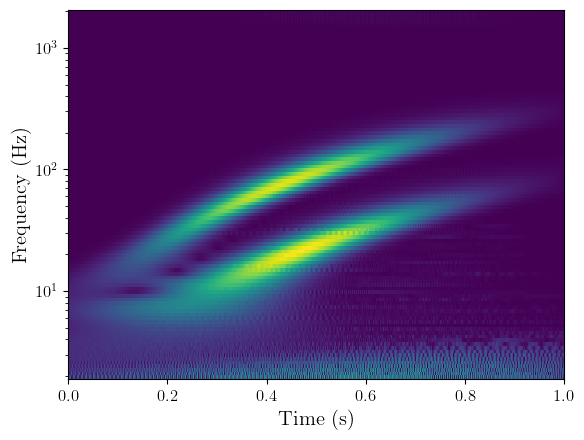

In [16]:
# performing CWT with complex Morlet wavelet

wavelet = 'cmor1.5-1.0'

widths = np.geomspace(1, 1024, num=100) # logarithmic scale for dilation
sampling_period = np.diff(t).mean()
cwmatr, freqs = pywt.cwt(
    chirp,
    widths,
    wavelet,
    sampling_period=sampling_period
)

cwmatr = np.abs(cwmatr)

fig, ax = plt.subplots()
pcm = ax.pcolormesh(t, freqs, cwmatr)
ax.set_yscale('log')
ax.set_xlabel('Time (s)', fontsize=15)
ax.set_ylabel('Frequency (Hz)', fontsize=15)

plt.show()

## Data preprocessing
### Fixing signal lengths

Before performing CWT on the ECG data, the data has to pass through a list of preprocessing steps (packaged in the 'data_preprocessing.py' file). As discussed previously, not all signals last a full minute. Although CWTs can be performed on signals of varying lengths, the images that are fed to the CNN must have a consistent dimensionality. Hence, signals that terminate before $60\:\rm{s}$ have to be padded with zeros. Additionally, it is also convenient to package all of the padded signals and their record numbers into an HDF5 file, which has already been done.

The fix_signal_length() function resizes all the signals to a length of $18,000$ sample points. For signals that are smaller, they are padded with zeros to the right. The few signals which are larger than this, they are terminated at the correct size.

In [17]:
def fix_signal_length(file_list):
    '''
    This function fixes the lengths of the ECG data. The maximum recording length is 60s, which at a sampling rate of 300 Hz, gives a signal length
    of 18,000. Readings that are given by arrays of length less than 18,000 are padded with zeros to the right. 

    The function takes as input a directory of all the .mat and .hea files from which the signals are extracted and flattened. Each of the padded
    array as stored in a 2d array that is returned as output.

    There are a few entries which slightly exceed 60s (hence, have more than 18,000 data points). Such entries have been restricted to array size of
    18,000.
    '''
    data_array = np.zeros((len(file_list), 18000)) # all the different signals are stored along the rows
    sampling_times = np.linspace(0.0, 60.0, 18000) 

    for i in range(len(file_list)):

        record = wfdb.rdrecord(file_list[i]).__dict__
        signal = record['p_signal'].flatten() *record['adc_gain']
        sig_len = record['sig_len']
        
        if sig_len < 18000:
            extra_dim = 18000 - sig_len # extra padding dimensions
            signal_padded = np.pad(signal, (0, extra_dim), 'constant', constant_values=0)
            data_array[i, :] = signal_padded

        elif sig_len == 18000:
            data_array[i, :] = signal # no padding if sig_len = 18000

        elif sig_len > 18000:
             data_array[i, :] = signal[0:18000] # truncate signal length to 18000

    return data_array, sampling_times 

data_array, sampling_times = fix_signal_length(data_list)
print(data_array)
print(f'The shape of the array is {data_array.shape}')

[[-127. -162. -197. ...    0.    0.    0.]
 [ 128.  157.  189. ...    0.    0.    0.]
 [  56.   73.   85. ...  -64.  -36.  -20.]
 ...
 [-202. -235. -272. ...    0.    0.    0.]
 [-227. -297. -374. ...    0.    0.    0.]
 [-237. -286. -338. ...    0.    0.    0.]]
The shape of the array is (8528, 18000)


### Signal cleaning and CWT

Like most signals, ECGs contain unwanted noise and other artifacts. One pervasive artifact in ECGs is what is called *baseline wander* where the signal is modulated by a low frequency wave. This occurs due to various factors and is undesirable. Before the signals are processed through a CWT, they are first cleaned through filters. This is done using neurokits nk.ecg_clean() function. The signal_CWT() function in the preprocessing file performs the required CWT on the signals and saves them as $(224\times224\times 3)$ arrays in the 'signal_cwt_images_training' folder.

In [18]:
def signal_CWT(raw_signal, sampling_rate=300, method='hamilton2002', wavelet='cmor2.5-1.0'):
    clean_signal = nk.ecg_clean(
        raw_signal,
        sampling_rate,
        method
    )
    scales = np.geomspace(1, 750, num=150)
    sampling_period = np.diff(sampling_times).mean()

    cwmat, freqs = pywt.cwt(
        clean_signal,
        scales,
        wavelet=wavelet,
        sampling_period=sampling_period
    )

    return np.abs(cwmat), freqs

In [19]:
_, freqs = signal_CWT(data_array[0,:])

print(freqs)

[299.98333333 286.94681817 274.4768369  262.54876941 251.13906549
 240.22519838 229.78562026 219.79971974 210.24778115 201.11094559
 192.37117374 184.01121021 176.01454951 168.36540341 161.04866981
 154.0499029  147.35528466 140.95159756 134.82619846 128.96699368
 123.36241508 118.00139727 112.87335569 107.9681658  103.27614303
  98.78802368  94.49494661  90.38843579  86.46038352  82.70303444
  79.10897023  75.67109493  72.38262098  69.23705578  66.22818886
  63.35007967  60.59704581  57.96365182  55.44469846  53.03521242
  50.73043654  48.52582038  46.41701125  44.39984561  42.47034088
  40.62468753  38.8592416   37.17051748  35.55518102  34.01004299
  32.53205274  31.1182922   29.76597011  28.47241651  27.23507747
  26.05151005  24.91937747  23.8364445   22.80057305  21.80971795
  20.8619229   19.95531661  19.08810914  18.25858831  17.46511635
  16.70612667  15.98012076  15.28566522  14.62138896  13.98598047
  13.37818521  12.7968032   12.24068657  11.70873737  11.19990532
  10.71318

The scalograms of the ECG signals that were plotted previously are shown here. Rich structures of frequency content now appear on the $2d$ plots as a function of time that would not have been possible to obtain if simply FFTs were considered. Above $20\:\rm{Hz}$, the frequency content becomes rather uniform, without any distinguishing patterns. Some of the interesting phenomena, however, occur in the low-frequency band of $0.5 - 5\:\rm{Hz}$.

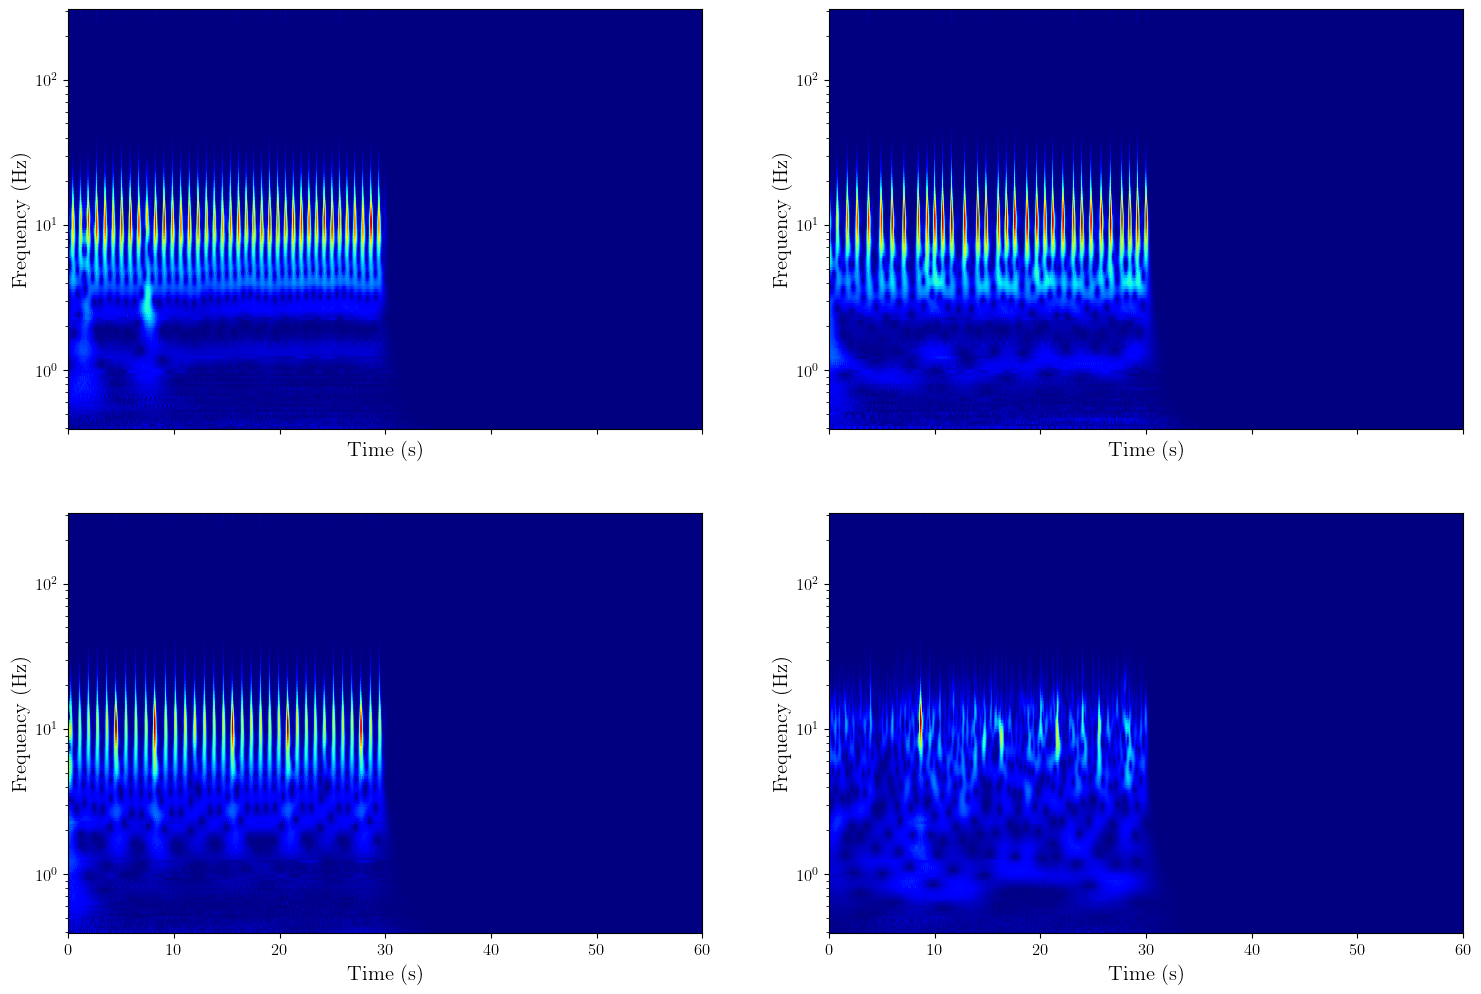

In [20]:
ll = [0, 3, 76, 1245] # previously plotted samples
annot = ['normal', 'afib', 'other', 'noise']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 12), sharex=True)

for col, ax in zip(ll, ax.ravel()):
    coeff_mat, freqs = signal_CWT(data_array[col, :])
    pcm = ax.pcolormesh(sampling_times, freqs, coeff_mat, cmap='jet')
    ax.set_xlabel(r'Time (s)', fontsize=15)  
    ax.set_ylabel(r'Frequency (Hz)', fontsize=15)
    ax.set_yscale('log')
plt.savefig('./images/ecg_cwt.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
def RandomScalogramGenerator(label_list, data_array, type):
    ''' 
    This function randomly generates scalogram of a chosen type of cardiac rhythm
    Type: 0 - Afib, 1 - Normal, 2 - Other, 3 - Noise
    '''
    label_subset = label_list[
        label_list['label']==type
    ].index.to_list()
    random_idx = np.random.choice(label_subset, size=1).item()
    raw_signal = data_array[random_idx, :]
    sampling_times = np.linspace(0.0, 60.0, 18000)

    coeff_mat, freq = signal_CWT(raw_signal)
    
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    ax[0].plot(sampling_times, raw_signal)
    pcm = ax[1].pcolormesh(sampling_times, freq, coeff_mat, cmap='jet')
    ax[1].set_yscale('log')
    plt.show()

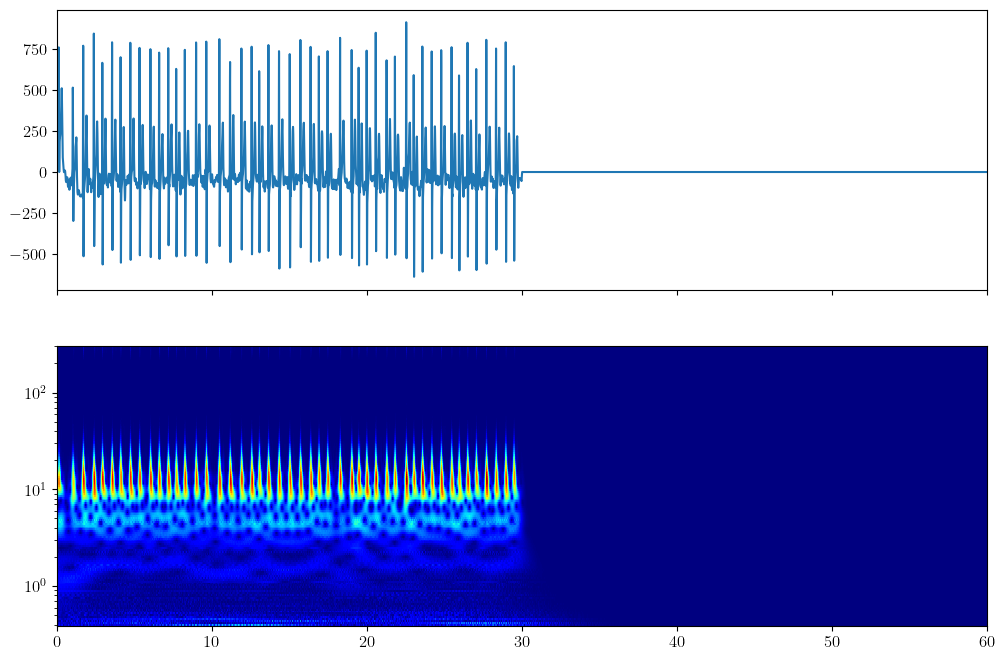

In [22]:
RandomScalogramGenerator(label_list, data_array, 0)